### Baseline
Simple neural netowrk model composed of solely fully-connected (Dense) layers. Activated with functions of ReLU function for line and region segregation, and softmax function at the output later for multiple class classifciation problem.
### Baseline model training and validation achievement: 
* Training accuracy: 62.92%
* Validation accuracy: 50.00%
### Baseline model test achievement: 
|           | Precision | Recall | F1-Score | Support |
|-----------|-----------|--------|----------|---------|
| Happy     | 0.43      | 0.43   | 0.43     | 54      |
| Sad       | 0.43      | 0.49   | 0.46     | 47      |
| Angry     | 0.50      | 0.45   | 0.47     | 49      |
|           |           |        |          |         |
| Accuracy  |           |        | 0.45     | 150     |
| Macro avg | 0.46      | 0.45   | 0.45     | 150     |
| Weighted avg | 0.46   | 0.45   | 0.45     | 150     |

### Dataset Analysis:
the dataset includes cat, dog and other species. additionally, an image may contains two species. 
* we should first do face detection from line segments, to segments grouping in order to form a small region or part of the face, to forming an entire face by grouping based on the regions. in the following layer, the model should be able to identify if the face is one of cat, dog, or wild animals. in this part, there will be at least 3 layers given there will be at least one for line segments, at least one for segment grouping into region, and at least one for face forming based on regions. Here the activation functions should be ReLU.
* (we do not have such labels) If we have labels for speicies catgory, multi-label classification should be performed here. in this case, in certain step we shoudl identify if the picture contains cat, dog, and e.g. rabbit or no. so the here it should be binary classification for each unit(neuron). e.g. only two classes, cat and dog. output y = [ bool_has_cat, bool_has_dog ]. Hence this layer should be for instance using sigmoid as activation function.
* given that the chance of having that emotion category is approximated, now this follwoing layer should further learn classify the probablility of being an emotion category such that in the activation function should be Softmax having output neurons of three : probability of happy, probability of angry, and probability of sad.

In [96]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import logging
logging.getLogger('tensorflow').setLevel
tf.autograph.set_verbosity(0)


### 1. Data pre-processing
* Since in the baseline model insteresed implementation should use conventional model, we'll stick with simple neural networks from draft for educational purposes, although it's important to note that this approach will possibily yield a very poor result for such a complex image processing task.
* First, you need to preprocess your images. This involves loading the images, resizing them to a uniform size, converting them to grayscale, and flattening them into vectors.

#### Benefits of Using Grayscale Images
Reduced Complexity: Grayscale images are less complex than color images, making them easier to process with simpler algorithms.
Reduced Computational Load: Grayscale images require less computational power and memory, as they have only one channel compared to three in color images.
Focus on Texture and Shape: Converting to grayscale can help the model focus on the texture and shape information, which might be more relevant for certain tasks like emotion detection in animals.

In [36]:
# Function to load and preprocess images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (128, 128))  # Resize to a fixed size for the model
            images.append(img)
    return images

### 2. Labeling the Data
If one has dataset for training and is without labels, one will need to assign labels to the data. Since we have separate folders for each emotion and labels for each data, we can skipp this part.
#### Define the path to the sub dataset folders

In [37]:
# Define the path to the dataset folders
happy_folder = "pets_facial_expression_dataset/happy"
sad_folder = "pets_facial_expression_dataset/Sad"
angry_folder = "pets_facial_expression_dataset/Angry"
other_folder = "pets_facial_expression_dataset/Other"

#### Load data and Combine data

In [38]:
# Load images and labels for each emotion
happy_images = load_images_from_folder(happy_folder)
sad_images = load_images_from_folder(sad_folder)
angry_images = load_images_from_folder(angry_folder)
# other_images = load_images_from_folder(other_folder)


# Create labels for each emotion category
happy_labels = [0] * len(happy_images)
sad_labels = [1] * len(sad_images)
angry_labels = [2] * len(angry_images)
# other_labels = [3] * len(other_folder)


# Concatenate images and labels
# X = np.array(happy_images + sad_images + angry_images + other_images)
# y = np.array(happy_labels + sad_labels + angry_labels + other_labels)

X = np.array(happy_images + sad_images + angry_images )
y = np.array(happy_labels + sad_labels + angry_labels )

# Normalize pixel values to range [0, 1]
X = X.astype('float32') / 255.0

# One-hot encode the labels
y = to_categorical(y, 3)

### 3. Splitting the Data
Split dataset into training and testing sets. This is essential for evaluating the performance of the model.
A common split is 80% for training and 20% for testing.

In [39]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

### 4. Define the Network Architecture
1. Face Detection and Segmentation (line, segments, face)
* **Objective**: Detect and segment animal faces from images.
* **Approach**: This typically requires convolutional neural networks (CNNs) that can identify patterns (like edges, textures) and group them into larger structures (like faces).
* **Layers**: Start with convolutional layers for feature extraction, followed by pooling layers to reduce dimensionality, and fully connected layers for classification.
Activation Functions: ReLU is commonly used in CNNs for its efficiency.
2. Species Identification (if we have the labels)
* **Objective**: Identify whether the image contains a cat, dog, or other species.
* **Approach**: This is a multi-label classification problem (since an image can have more than one label).
* **Layers**: Fully connected layers following the feature extraction layers.
* **Activation Function**:** Sigmoid activation function for each neuron (since it's a binary classification for each species).
3. Final Layer for Emotion Classification
* **Objective**: Classify the predominant emotion for each species.
* **Approach**: This is a classification problem, but with a twist. You're interested in the predominant emotion, which is a bit different from standard classification.
* **Layers**: Fully connected layer.
* **Activation Function**: Softmax if you're classifying one predominant emotion per species, or sigmoid for binary classification of each emotion.

### Additional Considerations:
* **Data Preprocessing**: Ensure images are properly preprocessed (normalized, resized, etc.).
* **Model Complexity**: This is a complex model. Start with a simpler version and iteratively add complexity.
* **Training Data**: You'll need a large and well-labeled dataset for this task, especially for the emotion detection and intensity levels.
* **Evaluation Metrics**: Choose appropriate metrics for each stage (accuracy, F1 score, mean squared error for intensity levels, etc.).
* **Computational Resources**: This model might require significant computational resources, especially for training.

### 5. Configure the NN
Since we have four output classes (happy, sad, angry, relaxed), the last output layer should have 4 neurons with a softmax activation function for multi-class classification.

In [112]:
# Build the simple neural netowrk model
# note: no sigmoid layers, four layers, and dropout layers 0.1, learning rate 0.000001 epoch 200 gives Training accuracy: 61.67% Validation accuracy: 51.67%
# Define the model
emotion_model = Sequential([
    Flatten(input_shape=(128, 128)),
    Dense(256, activation='relu', name="l1"),
    Dropout(0.1),  # Dropout layer after first Dense layer
    Dense(1024, activation='relu', name="l2"),
    Dropout(0.1),  # Dropout layer after second Dense layer
    Dense(50, activation='relu', name="l3"),
    Dropout(0.1),  # Dropout layer after third Dense layer
    Dense(3, activation='softmax', name="l4")  # Output layer for 3 classes with softmax activation
])

emotion_model.summary()

# Compile the model
emotion_model.compile(
    loss=CategoricalCrossentropy(from_logits=False),
    optimizer=Adam(learning_rate=0.000001),
    metrics=[CategoricalAccuracy()]
)



Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_43 (Flatten)        (None, 16384)             0         
                                                                 
 l1 (Dense)                  (None, 256)               4194560   
                                                                 
 dropout_125 (Dropout)       (None, 256)               0         
                                                                 
 l2 (Dense)                  (None, 1024)              263168    
                                                                 
 dropout_126 (Dropout)       (None, 1024)              0         
                                                                 
 l3 (Dense)                  (None, 50)                51250     
                                                                 
 dropout_127 (Dropout)       (None, 50)              

We can examine details of the model by first extracting the layers with `model.layers` and then extracting the weights with `layerx.get_weights()` as shown below.

### 6. Train the NN

In [113]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
# Train the model
history = emotion_model.fit(X_train, y_train, epochs=200, validation_split=0.2, callbacks=[early_stopping])


# For training accuracy and loss
training_accuracy = history.history['categorical_accuracy']
training_loss = history.history['loss']

# For validation accuracy and loss
validation_accuracy = history.history['val_categorical_accuracy']
validation_loss = history.history['val_loss']

# print the training and validation accuracy percentage
print(f"Training accuracy: {training_accuracy[-1]*100:.2f}%")
print(f"Validation accuracy: {validation_accuracy[-1]*100:.2f}%")

Epoch 1/200
15/15 [==============================] - 2s 74ms/step - loss: 1.1482 - categorical_accuracy: 0.3500 - val_loss: 1.1180 - val_categorical_accuracy: 0.3583
Epoch 2/200
15/15 [==============================] - 1s 62ms/step - loss: 1.1321 - categorical_accuracy: 0.2958 - val_loss: 1.1068 - val_categorical_accuracy: 0.3167
Epoch 3/200
15/15 [==============================] - 1s 60ms/step - loss: 1.1186 - categorical_accuracy: 0.3313 - val_loss: 1.1011 - val_categorical_accuracy: 0.3333
Epoch 4/200
15/15 [==============================] - 1s 67ms/step - loss: 1.0959 - categorical_accuracy: 0.3562 - val_loss: 1.0974 - val_categorical_accuracy: 0.3917
Epoch 5/200
15/15 [==============================] - 1s 69ms/step - loss: 1.0940 - categorical_accuracy: 0.3938 - val_loss: 1.0963 - val_categorical_accuracy: 0.3750
Epoch 6/200
15/15 [==============================] - 1s 67ms/step - loss: 1.0930 - categorical_accuracy: 0.3917 - val_loss: 1.0958 - val_categorical_accuracy: 0.3667
Epoc

### 7. Evaluate

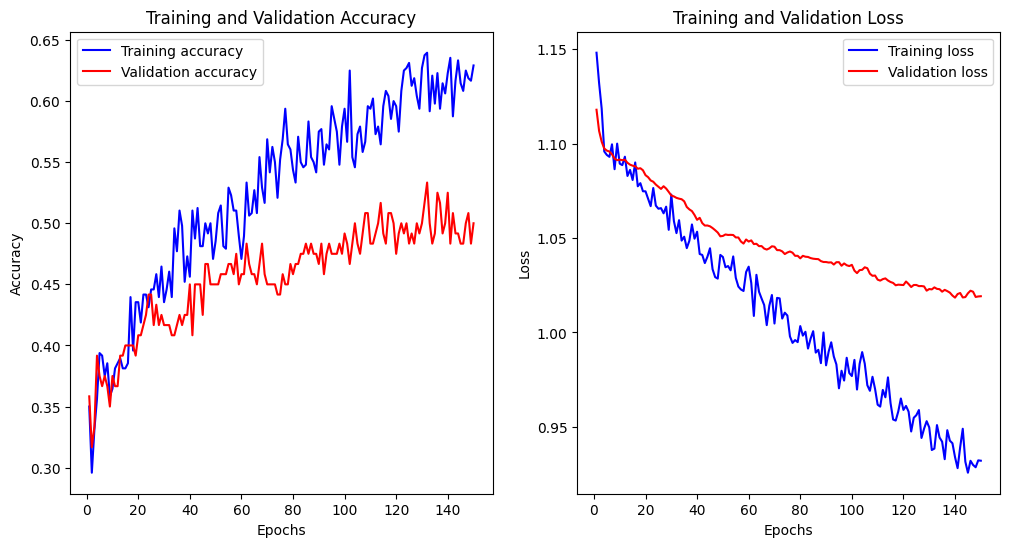

In [115]:
# # Predict on test data
import matplotlib.pyplot as plt

# Get the actual number of epochs model was trained for
n_epochs = len(training_accuracy)

epochs = range(1, n_epochs+1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_accuracy, 'b-', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'r-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, training_loss, 'b-', label='Training loss')
plt.plot(epochs, validation_loss, 'r-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [116]:
emotion_model.save('base_facial_emotion_model.h5')

/usr/local/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Visualizing Test Angry

1/1 [==============================] - 0s 122ms/step
Predicted Emotion: angry
Confidence [happy, sad, angry]: [0.34966367 0.19607942 0.4542568 ]


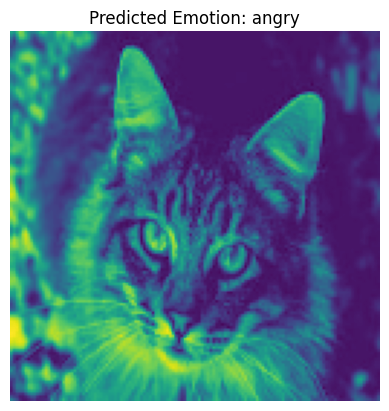

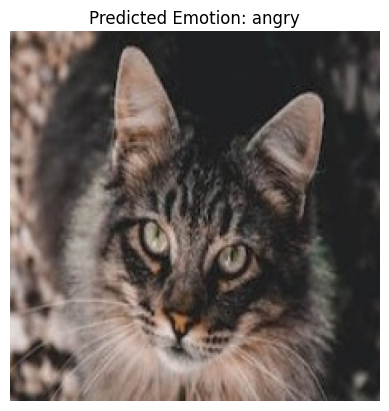

In [127]:
from keras.models import load_model
# Load the saved model
loaded_model = load_model("base_facial_emotion_model.h5")

# Load a custom test image
custom_test_image_path = "pets_facial_expression_dataset/Angry/35.jpg"

custom_test_image = cv2.imread(custom_test_image_path)
custom_test_image = cv2.cvtColor(custom_test_image, cv2.COLOR_BGR2GRAY)
custom_test_image = cv2.resize(custom_test_image, (128, 128))
custom_test_image = custom_test_image.astype('float32') / 255.0

# Reshape the image to match the model input shape
custom_test_image = np.expand_dims(custom_test_image, axis=0)
custom_test_image = np.expand_dims(custom_test_image, axis=-1)

# Make predictions on the custom test image
prediction = loaded_model.predict(custom_test_image)
prediction_prob = prediction[0]

emotion_label = np.argmax(prediction[0])

# Map the predicted label to emotion class
emotion_classes = {0: 'happy', 1: 'sad', 2: 'angry'}
predicted_emotion = emotion_classes[emotion_label]

# Print the custom test image and its predicted label
print(f"Predicted Emotion: {predicted_emotion}")
print(f"Confidence [happy, sad, angry]: {prediction_prob}")

import matplotlib.pyplot as plt

#Display the custom test image using matplotlib
plt.imshow(custom_test_image[0, :, :, 0])
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis('off')  # Hide axes
plt.show()

from PIL import Image
# Display the original custom test image using PIL
img_pil = Image.open(custom_test_image_path)
plt.imshow(np.array(img_pil))
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis('off')  # Hide axes
plt.show()

In [138]:
from sklearn.metrics import classification_report

# Get the model's predictions for the test set
y_pred = loaded_model.predict(X_test)

# Convert the predictions from categorical back to original
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=['Happy', 'Sad', 'Angry'])
print(report)

5/5 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

       Happy       0.43      0.43      0.43        54
         Sad       0.43      0.49      0.46        47
       Angry       0.50      0.45      0.47        49

    accuracy                           0.45       150
   macro avg       0.46      0.45      0.45       150
weighted avg       0.46      0.45      0.45       150



#### Visualize Test Happy

1/1 [==============================] - 0s 70ms/step
Predicted Emotion: happy
Confidence [happy, sad, angry]: [0.42281038 0.17208451 0.40510508]


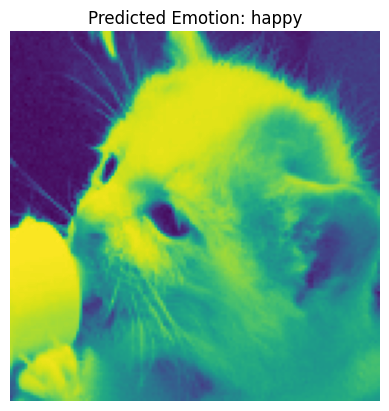

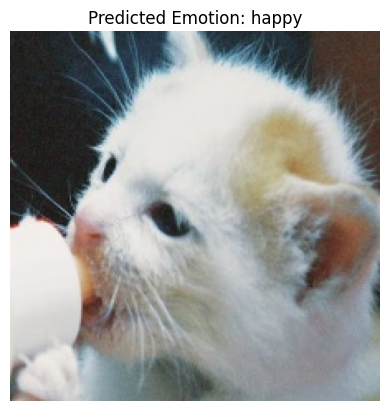

In [136]:
from keras.models import load_model
# Load the saved model
loaded_model = load_model("base_facial_emotion_model.h5")



# Function to load and preprocess images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (128, 128))  # Resize to a fixed size for the model
            images.append(img)
    return images


# Load a custom test image
custom_test_image_path = "pets_facial_expression_dataset/happy/020.jpg"

custom_test_image = cv2.imread(custom_test_image_path)
custom_test_image = cv2.cvtColor(custom_test_image, cv2.COLOR_BGR2GRAY)
custom_test_image = cv2.resize(custom_test_image, (128, 128))
custom_test_image = custom_test_image.astype('float32') / 255.0

# Reshape the image to match the model input shape
custom_test_image = np.expand_dims(custom_test_image, axis=0)
custom_test_image = np.expand_dims(custom_test_image, axis=-1)

# Make predictions on the custom test image
prediction = loaded_model.predict(custom_test_image)
prediction_prob = prediction[0]

emotion_label = np.argmax(prediction[0])

# Map the predicted label to emotion class
emotion_classes = {0: 'happy', 1: 'sad', 2: 'angry'}
predicted_emotion = emotion_classes[emotion_label]

# Print the custom test image and its predicted label
print(f"Predicted Emotion: {predicted_emotion}")
print(f"Confidence [happy, sad, angry]: {prediction_prob}")

import matplotlib.pyplot as plt

# Display the custom test image using matplotlib
plt.imshow(custom_test_image[0, :, :, 0])
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis('off')  # Hide axes
plt.show()

from PIL import Image
# Display the original custom test image using PIL
img_pil = Image.open(custom_test_image_path)
plt.imshow(np.array(img_pil))
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis('off')  # Hide axes
plt.show()

#### Visualizing Test Sad

1/1 [==============================] - 0s 117ms/step
Predicted Emotion: sad
Confidence [happy, sad, angry]: [0.27270073 0.46038383 0.26691544]


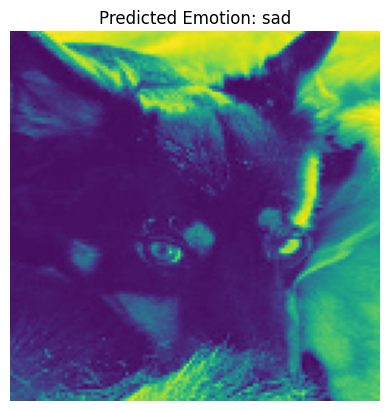

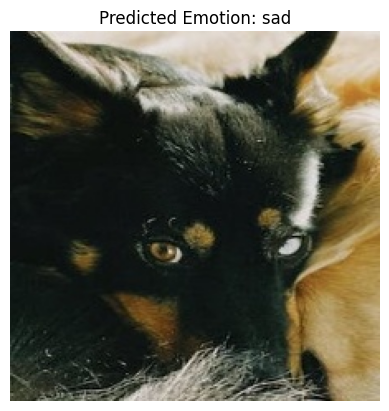

In [137]:
from keras.models import load_model
# Load the saved model
loaded_model = load_model("base_facial_emotion_model.h5")



# Function to load and preprocess images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (128, 128))  # Resize to a fixed size for the model
            images.append(img)
    return images


# Load a custom test image
custom_test_image_path = "pets_facial_expression_dataset/Sad/008.jpg"

custom_test_image = cv2.imread(custom_test_image_path)
custom_test_image = cv2.cvtColor(custom_test_image, cv2.COLOR_BGR2GRAY)
custom_test_image = cv2.resize(custom_test_image, (128, 128))
custom_test_image = custom_test_image.astype('float32') / 255.0

# Reshape the image to match the model input shape
custom_test_image = np.expand_dims(custom_test_image, axis=0)
custom_test_image = np.expand_dims(custom_test_image, axis=-1)

# Make predictions on the custom test image
prediction = loaded_model.predict(custom_test_image)
prediction_prob = prediction[0]

emotion_label = np.argmax(prediction[0])

# Map the predicted label to emotion class
emotion_classes = {0: 'happy', 1: 'sad', 2: 'angry'}
predicted_emotion = emotion_classes[emotion_label]

# Print the custom test image and its predicted label
print(f"Predicted Emotion: {predicted_emotion}")
print(f"Confidence [happy, sad, angry]: {prediction_prob}")

import matplotlib.pyplot as plt

#Display the custom test image using matplotlib
plt.imshow(custom_test_image[0, :, :, 0])
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis('off')  # Hide axes
plt.show()

from PIL import Image
# Display the original custom test image using PIL
img_pil = Image.open(custom_test_image_path)
plt.imshow(np.array(img_pil))
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis('off')  # Hide axes
plt.show()



## Limitations
* Feature Extraction: This approach uses very basic feature extraction (flattening the image), which might not capture the necessary details for accurate emotion classification.
* Model Complexity: Logistic regression is quite basic for image classification tasks.
* Data Quality: The quality and size of your dataset will significantly impact the performance of your model.